# Preparing Data and Model Building

In [1]:
#workflow and statistics
import pandas as pd
import numpy as np
import matplotlib as matplotlib
import matplotlib.pyplot as plt

#for showing missing values
import missingno as msno

#visualisation
import seaborn as sns

#natural language processing toolkit
import nltk
import string
from nltk.corpus import stopwords  # removes useless words
from nltk.stem.lancaster import LancasterStemmer  #converts the words to base form; aggressive
from nltk.stem import porter
from nltk.stem.util import suffix_replace, prefix_replace
from nltk.stem.api import StemmerI
from nltk.stem import SnowballStemmer

#create a wordcloud of often used words
import wordcloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
nltk.download('stopwords')

#accessing google cloud storage
from google.cloud import storage
from io import BytesIO
client = storage.Client()
bucket = "bilderkennung_nf_2020"

#building baseline classifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

# Grid search cross validation
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/drenizerama/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train_data = pd.read_csv("gs://bilderkennung_nf_2020/data /jigsaw-toxic-comment-train.csv")

In [3]:
valid_data = pd.read_csv("gs://bilderkennung_nf_2020/data /validation.csv")

In [4]:
train_data = train_data.drop('id', axis=1)

In [5]:
train_data.head(2)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0


In [6]:
valid_data = valid_data.drop('id', axis=1)

In [7]:
valid_data.head(2)

,comment_text,lang,toxic
0,Este usuario ni siquiera llega al rango de ...,es,0
1,Il testo di questa voce pare esser scopiazzato...,it,0


## Preprocessing

In [8]:
def remove_punctuation(text):
    '''a function for removing punctuation'''
    import string
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)
train_data['comment_text'] = train_data['comment_text'].apply(remove_punctuation)
valid_data['comment_text'] = valid_data['comment_text'].apply(remove_punctuation)

In [9]:
sw=stopwords.words('english')
def removesw(text):
    '''a function for removing the stopword'''
    # removing the stop words and lowercasing the selected words
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    # joining the list of words with space separator
    return " ".join(text)
train_data['comment_text'] = train_data['comment_text'].apply(removesw)
valid_data['comment_text'] = valid_data['comment_text'].apply(removesw)

In [10]:
stemmer = SnowballStemmer("english")

def stemming(text):    
    '''a function which stems each word in the given text'''
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text) 
train_data['comment_text'] = train_data['comment_text'].apply(stemming)
valid_data['comment_text'] = valid_data['comment_text'].apply(stemming)

# Baseline Model: Logistic Regression

Logistic Regression is [well suited](https://blog.insightdatascience.com/always-start-with-a-stupid-model-no-exceptions-3a22314b9aaa) as a baseline model for classification and natural language processing. Baseline models take less tims to construct since there architecture is relatively simple. They are easier and faster to train, so you can iterate quickly through them. This advantage helps to deal with bugs that point to data issues, as well.
Hence, they give you information to build on in a short time. Baseline models function as benchmarks for more complex models. By studying the shortcomings and struggles of our baseline model we can make decisions on what complex model to deploy next. Therefore, the baseline model also gives a methodological orientation. 

**Vectorizer**

In [11]:
tfidf_vec = TfidfVectorizer(max_df=0.7,stop_words='english')

**Regression Model: predicting 'toxic'**

In [12]:
X = train_data['comment_text']
y = train_data['toxic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train_vec = tfidf_vec.fit_transform(X_train)
X_test_vec = tfidf_vec.transform(X_test)

log_toxic = LogisticRegression()
log_toxic.fit(X_train_vec,y_train)

predictions = log_toxic.predict(X_test_vec)
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[66046   719]
 [ 2953  4054]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     66765
           1       0.85      0.58      0.69      7007

    accuracy                           0.95     73772
   macro avg       0.90      0.78      0.83     73772
weighted avg       0.95      0.95      0.95     73772



/home/drenizerama/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Out baseline model (Logistic Regression) performs with 95% accuracy on the training data.
However, since we habe imbalanced data, we want to improve on the precision and recall values.

Accuracy:  0.950225017621862


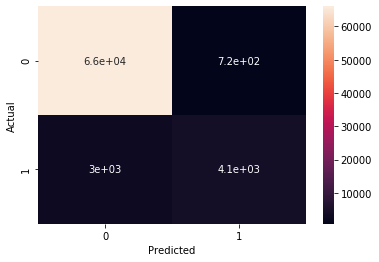

In [13]:
confusion_matrix = pd.crosstab(y_test, predictions, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)

print('Accuracy: ',metrics.accuracy_score(y_test, predictions))

In [ ]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l2 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train_vec,y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 10.0, 'penalty': 'l2'}
accuracy : 0.950686690973072

**Resampling imbalanced data**

In [17]:
from imblearn.over_sampling import SMOTE

In [18]:
sm = SMOTE(random_state = 2)

X_train_res, y_train_res = sm.fit_sample(X_train_vec, y_train.ravel())

**Execute GridSearch for Model Optimization**

In [ ]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l2 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train_res,y_train_res)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1000.0, 'penalty': 'l2'}
accuracy : 0.9467282127031019